# 3.9.2: Baseball 

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap08.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap08 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap08.py


In the previous notebook we developed a model of the flight of a
baseball.  In this notebook we apply that model to an optimization problem. In general, *optimization* is a process for improving a design by searching for the parameters that maximize a benefit or minimize a cost. For example, in this chapter we'll find the angle you should hit a baseball to maximize the distance it travels. And we'll use a new function, called `minimize_scalar` that searches for this angle efficiently.

## Optimizing a baseball flight

There has long been a debate among baseball players and coaches about how the angle of approach of a baseball swing.  Should a player swing "up" on the ball in an attempt to increase the launch angle of the ball?  Or is it better to make a level swing that drives the ball in a horizontal direction?

<br>

We're probably not going to solve that argument, but we can at least make a contribution.  What launch angle will actually produce the longest fly ball?

### Creating a system

We're going to use the simulation that we developed in the exercise of the previous notebook and a function called `minimize_scalar` to find an answer.  We'll start with the data about the drag coefficient of a baseball, our set of parameters, and a system:

In [ ]:
# Create a interpolated function for the drag coefficient of a baseball
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/baseball_drag.csv'
cd_data = pd.read_csv(filename)
mph_to_mps = 0.44704
index = cd_data['Velocity in mph'].values * mph_to_mps
cd_func = interp1d(index,cd_data['Drag coefficient'])



In [ ]:
# Convert feet to meters
feet_to_meter = 0.3048
params = dict(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    cd_func = cd_func,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,    # s
    )      

We'll need to adjust the `make_system` function to include our new parameters:

In [ ]:
def make_system(params):
    
    x, y, angle, speed, mass, diameter, cd_func, rho, g, t_end = params.values()
    
    # compute x and y components of velocity
    vx, vy = angle_to_components(speed,angle)
    
    # make the initial state
    init = pd.Series(dict(x=x, y=y, vx=vx, vy=vy))
    
    # compute the frontal area
    area = np.pi * (diameter/2)**2

    return dict(cd_func=cd_func, rho=rho, g=g, t_end=t_end,
                  mass=mass, init = init,
                  area = area)
    


✅ Active reading: A projectile without drag will achieve its maximum distance when launched at a 45 degree angle.  When we include drag, do you think the optimal angle will be at, above or below 45 degrees?  Why?  

✅ ✅ Answer here.


### Finding the Range

We want to find the launch angle that maximizes the *range*, that is, the distance the ball travels in the air before landing. We'll use a function in a SciPy function called `minimize_scalar`, which takes a function and finds its minimum.  It might seem odd to use a "minimize" function to find the maximum range, but minimization problems are easier to formulate than maximization problems, and so computer algorithms are often designed to minimize.  As we'll see, it's easy enough to use a minimization algorithm to maximize a value (i.e. a scalar).

<br>

The function we pass to `minimize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [ ]:
def range_func(angle, params):
    params_var = params.copy()
    params_var.update(dict(angle=angle))
    system = make_system(params_var)
    results, details = run_solve_ivp(system, slope_func_var,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    return -x_dist

`range_func` makes a new `system` object with the given value of
`angle`. Then it calls `run_solve_ivp` and
returns the final value of `x` from the results (you might remember that our event function stops the simulation when the ball hits the ground).  In short, it tells us how far a ball will travel at the angle and speed given by the parameters.  Notice that since we want to *maximize* our function, we're multiplying `x_dist` by -1: this means that the "minimum" value of the function will actually be the largest $x$ value.

<br>

We can call `range_func` directly like this:

In [ ]:
range_func(45, params)

-90.20664656623313

With launch angle 45°, the ball lands about 90 meters from home plate.  Test the prediction you made above: about what angle produces the longest distance?

<br>

Now we can sweep a sequence of angles like this:

In [ ]:
angles = np.linspace(20, 80, 21)
sweep = pd.Series([],dtype=np.float64)

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

Here's what the results look like.

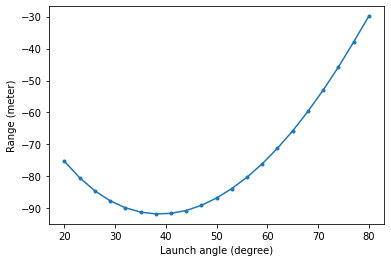

In [ ]:
sweep.plot(xlabel='Launch angle (degree)',
         ylabel='Range (meter)',marker='.');

The dots represent actual data points determined by `range_func`.  It looks like the range is maximized when the initial angle is near 39°.

✅ Active reading: Add documentation to the function `range_func` above.

### Finding the optimal angle

To find the optimal angle more precisely and more efficiently, we can use a SciPy algorithm called `minimize_scalar`.  Notice that range function has two arguments: `angle` and `params`.  When `minimize_scalar` is called, it will attempt to minimize the value of the `range_func` by sweeping through possible values for the first argument in the `range_func`, which in our case is `angle`.  

In [ ]:
res = spo.minimize_scalar(range_func, args=params)

The first parameter is `range_func`, the function we want to minimize.  `args` is a *keyword argument* that allows us to pass `params` on to `range_func`.

<br>

The return value from `minimize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the function value at that angle (i.e. the distance the ball travels when the ball is launched at the optimal angle).

In [ ]:
res

     fun: -91.76249277506469
    nfev: 31
     nit: 24
 success: True
       x: 38.75878769190016

In [ ]:
print("When hit at an angle of", round(res.x,2), ", the ball travels", -round(res.fun,2), "meters")

When hit at an angle of 38.76 , the ball travels 91.76 meters


For these parameters, the optimal angle is just under 39°, which yields a range of almost 92 m.


---

## Summary

This notebook introduces an new tool, `minimize_scalar`, that provides an efficient way to search for the maximum of a function. We used it to find the launch angle that maximizes the distance a baseball flies through the air, given its initial velocity.

<br>

---


## Exercise 1

Baseball players don't just want to hit the ball far: they want to hit it high enough to get over the outfield fence.   Describe what you could do to the code to find the distance $x$ that the ball could clear the fence.  Be specific about what you which function need to change and how (slope function, drag force function, event function, etc...).

✅ ✅  Answer here


In [ ]:
# Here is the code that is in use in this simulation for reference
def drag_force_var(V, system, cd_func):
    rho, area = system['rho'], system['area']
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    C_d = cd_func(vel_mag)
    if vel_mag != 0:
        dir = V/vel_mag
    else:
        dir = pd.Series(dict(x = 0, y = 0), dtype = float)
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)
    f_drag = drag_mag * -dir

    return f_drag


def slope_func_var(t, state, system):
    x, y, vx, vy = state
    mass, g, cd_func = system['mass'], system['g'], system['cd_func']
    
    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force_var(V, system, cd_func) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y  


def event_func(t, state, system):
    x, y, vx, vy = state
    return y